In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import pickle
import pickle
import math
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt


In [13]:
# read pickle as dataframe
pickle_path = "../nikos/uncertainty/wandb/run-20250414_225134-35cwfjoe/files/train_generations.pkl"

In [14]:
def compare_gnll_vs_prob_auroc_with_rouge(pickle_path, verbose=False):
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)

    y_true = []
    gnll_uncertainties = []
    conf_uncertainties = []

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    total = 0
    correct = 0

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    for example_id, entry in data.items():
        pred_answer = entry['most_likely_answer']['response'].strip().lower()
        true_answers = [ans.strip().lower() for ans in entry['reference']['answers']['text']]
        is_correct = int(pred_answer in true_answers)
        y_true.append(is_correct)

        total += 1
        correct += is_correct

        # Compute G-NLL
        token_log_likelihoods = entry['most_likely_answer']['token_log_likelihoods']
        sequence_nll = -sum(token_log_likelihoods)
        gnll_uncertainties.append(sequence_nll)

        # Confidence-based uncertainty
        try:
            sequence_prob = float(entry['most_likely_answer']['sequence_prob'])
        except (ValueError, TypeError):
            sequence_prob = math.exp(-sequence_nll)  # fallback

        conf_uncertainties.append(1.0 - sequence_prob)

        # Compute ROUGE scores using the best matching reference
        best_rouge1 = best_rouge2 = best_rougeL = 0
        for ref in true_answers:
            scores = scorer.score(ref, pred_answer)
            best_rouge1 = max(best_rouge1, scores['rouge1'].fmeasure)
            best_rouge2 = max(best_rouge2, scores['rouge2'].fmeasure)
            best_rougeL = max(best_rougeL, scores['rougeL'].fmeasure)

        rouge1_scores.append(best_rouge1)
        rouge2_scores.append(best_rouge2)
        rougeL_scores.append(best_rougeL)

    # Compute AUROCs
    try:
        gnll_auroc = roc_auc_score(y_true, gnll_uncertainties)
        prob_auroc = roc_auc_score(y_true, conf_uncertainties)
    except ValueError as e:
        print(f"Error computing AUROC: {e}")
        gnll_auroc, prob_auroc = None, None

    accuracy = correct / total if total > 0 else 0

    return {
        'G-NLL_AUROC': gnll_auroc,
        'Confidence_AUROC': prob_auroc,
        'Accuracy': accuracy,
        'Avg_ROUGE-1': sum(rouge1_scores)/len(rouge1_scores) if rouge1_scores else 0,
        'Avg_ROUGE-2': sum(rouge2_scores)/len(rouge2_scores) if rouge2_scores else 0,
        'Avg_ROUGE-L': sum(rougeL_scores)/len(rougeL_scores) if rougeL_scores else 0
    }


In [15]:
results = compare_gnll_vs_prob_auroc_with_rouge(pickle_path, verbose=False)
print("Accuracy:", results['Accuracy'])
print("G-NLL AUROC:", results['G-NLL_AUROC'])
print("Confidence AUROC (1 - sequence_prob):", results['Confidence_AUROC'])

Accuracy: 0.245
G-NLL AUROC: 0.15562913907284767
Confidence AUROC (1 - sequence_prob): 0.15562913907284767


In [23]:
def evaluate_with_rouge_thresholds(pickle_path, rougeL_thresholds=[0.0, 0.1, 0.3, 0.5, 0.7,]):
    with open(pickle_path, 'rb') as f:
        data = pickle.load(f)

    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    results = {}

    for threshold in rougeL_thresholds:
        y_true = []
        gnll_uncertainties = []
        conf_uncertainties = []

        correct_count = 0
        total = 0

        for entry in data.values():
            pred = entry['most_likely_answer']['response'].strip().lower()
            references = [r.strip().lower() for r in entry['reference']['answers']['text']]

            # Best ROUGE-L across references
            best_rougeL = 0.0
            for ref in references:
                score = scorer.score(ref, pred)
                best_rougeL = max(best_rougeL, score['rougeL'].fmeasure)

            is_correct = int(best_rougeL >= threshold)
            y_true.append(is_correct)
            correct_count += is_correct
            total += 1

            # G-NLL and Confidence
            log_likelihoods = entry['most_likely_answer']['token_log_likelihoods']
            nll = -sum(log_likelihoods)
            gnll_uncertainties.append(nll)

            try:
                sequence_prob = float(entry['most_likely_answer']['sequence_prob'])
            except (ValueError, TypeError):
                sequence_prob = math.exp(-nll)

            conf_uncertainties.append(1.0 - sequence_prob)

        accuracy = correct_count / total if total > 0 else 0

        try:
            gnll_auroc = roc_auc_score(y_true, gnll_uncertainties)
            prob_auroc = roc_auc_score(y_true, conf_uncertainties)
        except ValueError:
            gnll_auroc = None
            prob_auroc = None

        results[threshold] = {
            'Accuracy': accuracy,
            'G-NLL_AUROC': gnll_auroc,
            'Confidence_AUROC': prob_auroc,
        }

    return results


In [24]:
def plot_accuracy_vs_auroc(results_dict, title="Accuracy vs AUROC at ROUGE-L Thresholds"):
    thresholds = list(results_dict.keys())
    accuracies = [results_dict[t]['Accuracy'] for t in thresholds]
    gnll_aurocs = [results_dict[t]['G-NLL_AUROC'] for t in thresholds]
    conf_aurocs = [results_dict[t]['Confidence_AUROC'] for t in thresholds]

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies, marker='o', label='Accuracy')
    plt.plot(thresholds, gnll_aurocs, marker='x', label='G-NLL AUROC')
    plt.plot(thresholds, conf_aurocs, marker='^', label='Confidence AUROC')

    plt.xlabel('ROUGE-L Correctness Threshold')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


C:\Users\nikos\anaconda3\envs\nllSAR\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\nikos\anaconda3\envs\nllSAR\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Threshold 0.0 -> Accuracy: 1.000, G-NLL AUROC: nan, Conf AUROC: nan
Threshold 0.1 -> Accuracy: 0.350, G-NLL AUROC: 0.20887362637362636, Conf AUROC: 0.20887362637362636
Threshold 0.3 -> Accuracy: 0.347, G-NLL AUROC: 0.2067587309462775, Conf AUROC: 0.2067587309462775
Threshold 0.5 -> Accuracy: 0.333, G-NLL AUROC: 0.18647742952887836, Conf AUROC: 0.18647742952887836
Threshold 0.7 -> Accuracy: 0.280, G-NLL AUROC: 0.17159598214285715, Conf AUROC: 0.17159598214285715


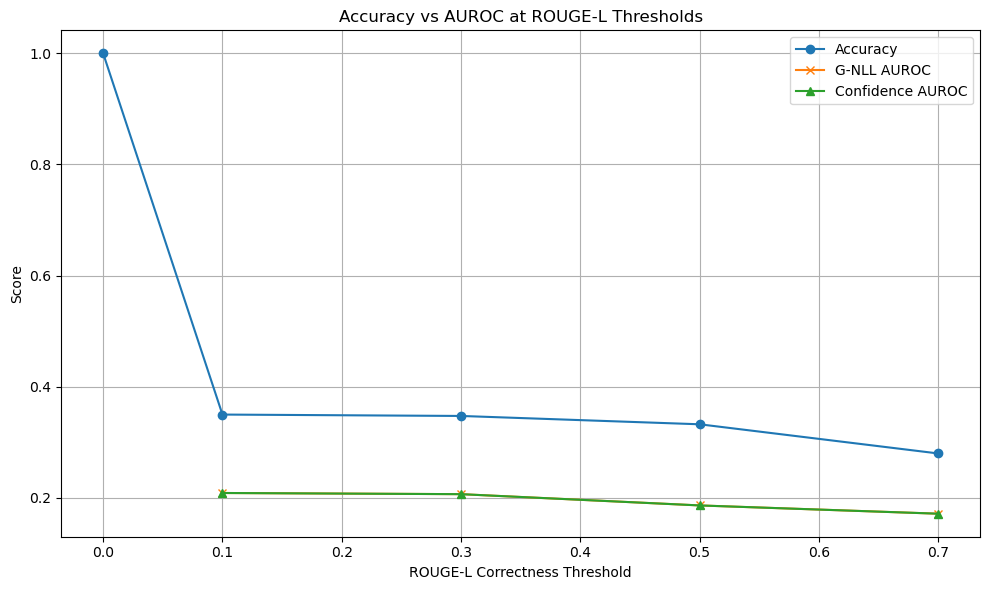

In [25]:
results = evaluate_with_rouge_thresholds(pickle_path)

for t, vals in results.items():
    print(f"Threshold {t:.1f} -> Accuracy: {vals['Accuracy']:.3f}, G-NLL AUROC: {vals['G-NLL_AUROC']}, Conf AUROC: {vals['Confidence_AUROC']}")

plot_accuracy_vs_auroc(results)

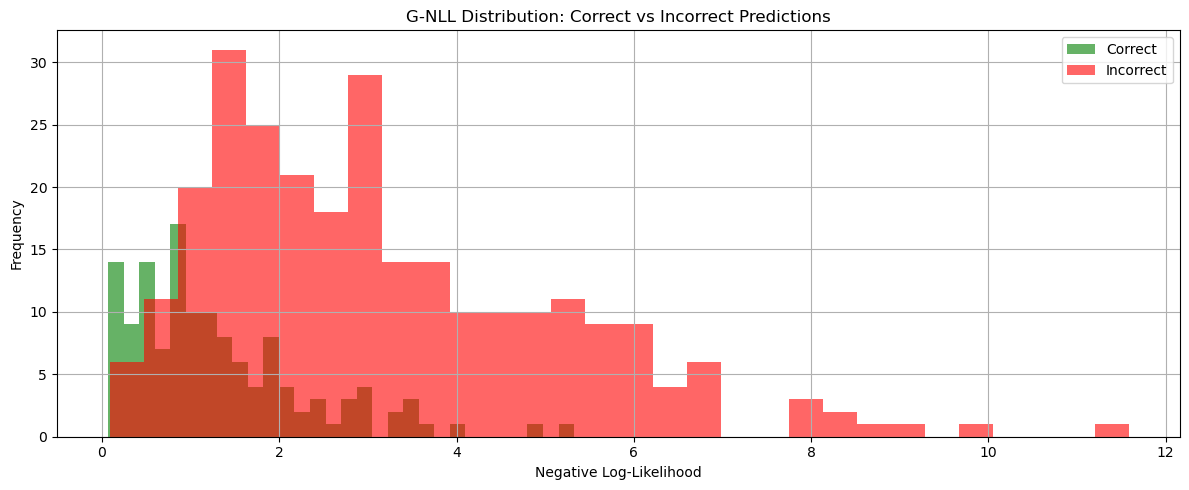

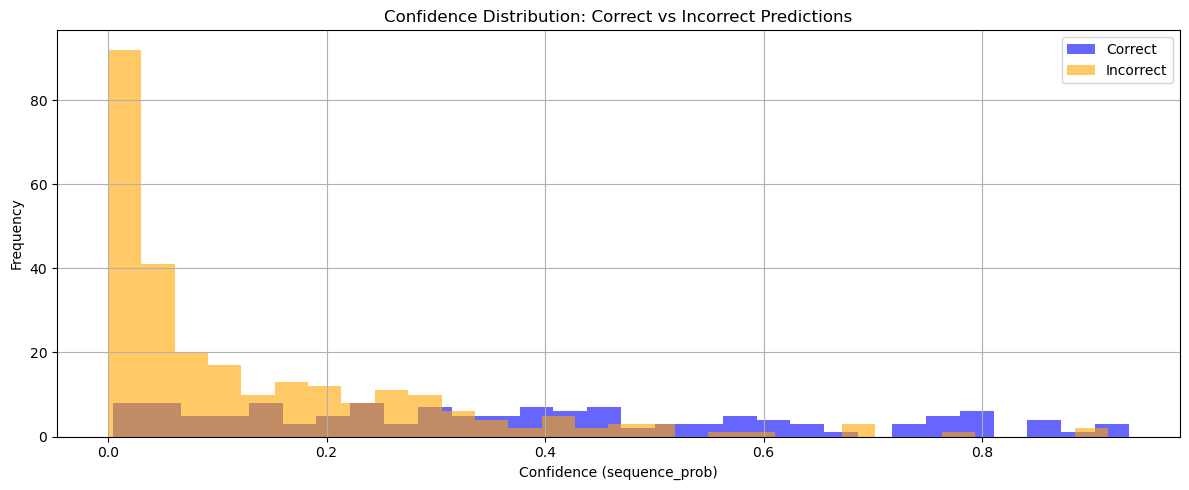

                           Example ID              Prediction  \
0   sfq_7181--189/189_1916422.txt#0_2                 sternum   
1      qw_2792--99/99_1104503.txt#0_0                   bread   
2     odql_11832--9/9_2297681.txt#0_1                alberich   
3  odql_4333--106/106_2158837.txt#0_1             labradoodle   
4   sfq_16170--142/142_233837.txt#0_1               leicester   
5     qw_14505--102/102_67417.txt#0_0  the straits of florida   
6        qz_3041--53/53_46469.txt#0_0           sirhan sirhan   
7   dpql_3059--151/151_452073.txt#0_2                hannibal   
8    qw_4976--179/179_3207675.txt#0_0              every year   
9  sfq_13408--130/130_2486878.txt#0_1             tina turner   

             References  Confidence   ROUGE-L  
0           [manubrium]    0.915515  0.000000  
1               [bread]    0.158093  1.000000  
2            [alberich]    0.054125  1.000000  
3         [labradoodle]    0.195021  1.000000  
4           [leicester]    0.085237  1.00000

In [26]:
import pickle
import math
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import pandas as pd

# Load data
with open(pickle_path, 'rb') as f:  # <- Replace with your pickle file path
    data = pickle.load(f)

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
high_conf_low_rouge = []
low_conf_high_rouge = []
correct_nll = []
incorrect_nll = []
correct_conf = []
incorrect_conf = []

threshold = 0.5

for example_id, entry in data.items():
    pred = entry['most_likely_answer']['response'].strip().lower()
    refs = [r.strip().lower() for r in entry['reference']['answers']['text']]
    best_rougeL = max(scorer.score(ref, pred)['rougeL'].fmeasure for ref in refs)

    nll = -sum(entry['most_likely_answer']['token_log_likelihoods'])
    try:
        sequence_prob = float(entry['most_likely_answer']['sequence_prob'])
    except:
        sequence_prob = math.exp(-nll)

    is_correct = best_rougeL >= threshold

    if is_correct:
        correct_nll.append(nll)
        correct_conf.append(sequence_prob)
    else:
        incorrect_nll.append(nll)
        incorrect_conf.append(sequence_prob)

    if sequence_prob > 0.9 and best_rougeL < 0.3:
        high_conf_low_rouge.append((example_id, pred, refs, sequence_prob, best_rougeL))
    elif sequence_prob < 0.2 and best_rougeL > 0.7:
        low_conf_high_rouge.append((example_id, pred, refs, sequence_prob, best_rougeL))

# Plot NLL hist
plt.figure(figsize=(12, 5))
plt.hist(correct_nll, bins=30, alpha=0.6, label='Correct', color='green')
plt.hist(incorrect_nll, bins=30, alpha=0.6, label='Incorrect', color='red')
plt.title('G-NLL Distribution: Correct vs Incorrect Predictions')
plt.xlabel('Negative Log-Likelihood')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot confidence hist
plt.figure(figsize=(12, 5))
plt.hist(correct_conf, bins=30, alpha=0.6, label='Correct', color='blue')
plt.hist(incorrect_conf, bins=30, alpha=0.6, label='Incorrect', color='orange')
plt.title('Confidence Distribution: Correct vs Incorrect Predictions')
plt.xlabel('Confidence (sequence_prob)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show example mismatches
df = pd.DataFrame(
    high_conf_low_rouge + low_conf_high_rouge,
    columns=["Example ID", "Prediction", "References", "Confidence", "ROUGE-L"]
)
pd.set_option('display.max_colwidth', None)
print(df.head(10))  # print first few for inspection
